In [1]:
#All imports here
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


# Some constants 
SAMPLE_SUBMISSION_PATH="/home/hector/Documentos/iimas/club/sample_submission.csv"
INPUT_FOLDER="/home/hector/Documentos/iimas/club/stage1/"
MODEL_PATH="model.ckpt"

IMG_SIZE_PX = 40
SLICE_COUNT = 20

"""
INPUT_FOLDER = '/media/ivanvladimir/musica/stage1/'
patients = os.listdir(INPUT_FOLDER)
patients.sort()
print (patients)


"""

/usr/local/lib/python3.5/dist-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


"\nINPUT_FOLDER = '/media/ivanvladimir/musica/stage1/'\npatients = os.listdir(INPUT_FOLDER)\npatients.sort()\nprint (patients)\n\n\n"

In [2]:
#important functions
# Load the scans in given folder path
def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices
MIN_BOUND = -1000.0
MAX_BOUND = 400.0
    
def normalize(image):
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image>1] = 1.
    image[image<0] = 0.
    return image

PIXEL_MEAN = 0.25

def zero_center(image):
    image = image - PIXEL_MEAN
    return image

def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
        #image[slice_number]=normalize(zero_center(image[slice_number]))
        #Revisar esto para saber cómo funciona
    return np.array(image, dtype=np.int16)
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness] + scan[0].PixelSpacing, dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round([new_real_shape[0],52,52])
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, (real_resize_factor), mode='nearest')
    #image.resize((SLICE_COUNT, IMG_SIZE_PX, IMG_SIZE_PX))
    return image[-20:], new_spacing
"""
Created on Tue Mar  7 12:33:50 2017

@author: juan
"""

import naturalCubicSpline as spline
import numericalIntegral

import csv
values_juan={}
with open('splineData.csv', 'r') as csvfile:
    values_reader = csv.reader(csvfile)
    
    for row in values_reader:
        try:
            values_juan[float(row[0])]=float(row[1])
        except ValueError:
            pass
    
def g_(i):
    if i <-999:
        i=-999
    if i>0:
        return i
    return values_juan[i]
    
def get_pixels_juan(slices):
    vfunc = np.vectorize(g_)
    slices=vfunc(slices)
    return slices

In [3]:
#Load patient id's
pat_ids = pd.read_csv(SAMPLE_SUBMISSION_PATH, index_col=0).index
print(pat_ids)


Index(['026470d51482c93efc18b9803159c960', '031b7ec4fe96a3b035a8196264a8c8c3',
       '03bd22ed5858039af223c04993e9eb22', '06a90409e4fcea3e634748b967993531',
       '07b1defcfae5873ee1f03c90255eb170', '0b20184e0cd497028bdd155d9fb42dc9',
       '12db1ea8336eafaf7f9e3eda2b4e4fef', '159bc8821a2dc39a1e770cb3559e098d',
       '174c5f7c33ca31443208ef873b9477e5', '1753250dab5fc81bab8280df13309733',
       ...
       'f4d23e0272a2ce5bfc7f07033d4f2e7d', 'f5ff7734997820b45dafa75dff60ece8',
       'f7c387290d7e3074501eac167c849000', 'f89e3d0867e27be8e19d7ed50e1eb7e8',
       'fad57a1078ddbc685e517bd8f24aa8ac', 'fb55849cee6473974612c17f094a38cd',
       'fb5874408966d7c6bebd3d84a5599e20', 'fcfab3eddbdf0421c39f71d651cc5c56',
       'fdcd385b0d2d12341661e1abe845be0b', 'ff8599dd7c1139be3bad5a0351ab749a'],
      dtype='object', name='id', length=198)


In [4]:
#Load data and preprocesing

much_data = []
num=0
for patient in pat_ids[0:5]:
    num=num+1
    print(patient,num)
    patient = load_scan(INPUT_FOLDER + patient)
    patient_pixels = get_pixels_hu(patient)
    patient_pixels = get_pixels_juan(patient_pixels)
    pix_resampled, spacing = resample(patient_pixels, patient, [10,5,5])
    #print(pix_resampled.shape)
    #segmented_lungs = segment_lung_mask(pix_resampled, False)
    #segmented_lungs_fill = segment_lung_mask(pix_resampled, True)

    #img_data,label = process_data(patient,labels,img_px_size=IMG_SIZE_PX, hm_slices=SLICE_COUNT)
    #print(img_data.shape,label)
    much_data.append(pix_resampled)



#np.save('muchdata-{}-{}-{}.npy'.format(IMG_SIZE_PX,IMG_SIZE_PX,SLICE_COUNT), much_data)
np.save('muchdata.npy', much_data)

026470d51482c93efc18b9803159c960 1
031b7ec4fe96a3b035a8196264a8c8c3 2
03bd22ed5858039af223c04993e9eb22 3
06a90409e4fcea3e634748b967993531 4
07b1defcfae5873ee1f03c90255eb170 5


Instructions for updating:
Use `tf.global_variables_initializer` instead.
[[[-999.73321687 -999.73321687 -999.73321687 ..., -999.73321687
   -999.73321687 -999.73321687]
  [-999.73321687 -999.73321687 -999.73321687 ..., -999.73321687
   -999.73321687 -999.73321687]
  [-999.73321687 -999.73321687 -999.73321687 ..., -999.73321687
   -999.73321687 -999.73321687]
  ..., 
  [-999.73321687 -999.73321687 -999.73321687 ..., -999.73321687
   -999.73321687 -999.73321687]
  [-999.73321687 -999.73321687 -999.73321687 ..., -999.73321687
   -999.73321687 -999.73321687]
  [-999.73321687 -999.73321687 -999.73321687 ..., -999.73321687
   -999.73321687 -999.73321687]]

 [[-999.73321687 -999.73321687 -999.73321687 ..., -999.73321687
   -999.73321687 -999.73321687]
  [-999.73321687 -999.73321687 -999.73321687 ..., -999.73321687
   -999.73321687 -999.73321687]
  [-999.73321687 -999.73321687 -999.73321687 ..., -999.73321687
   -999.73321687 -999.73321687]
  ..., 
  [-999.73321687 -999.73321687 -999.73321687

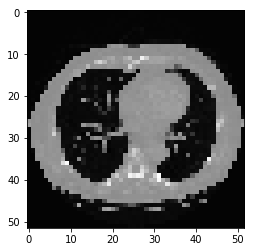

InvalidArgumentError: Input to reshape is a tensor with 2704 values, but the requested shape requires a multiple of 32000
	 [[Node: Reshape_8 = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_Placeholder_8_0, Reshape_8/shape)]]

Caused by op 'Reshape_8', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/hector/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/hector/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/hector/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/hector/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/hector/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/hector/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/hector/.local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/hector/.local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/hector/.local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/hector/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/hector/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/hector/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/hector/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/hector/.local/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/hector/.local/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/hector/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/hector/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2827, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/hector/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-ddafbf02ff48>", line 83, in <module>
    print(predict(x))
  File "<ipython-input-10-ddafbf02ff48>", line 56, in predict
    prediction = convolutional_neural_network(x)
  File "<ipython-input-10-ddafbf02ff48>", line 36, in convolutional_neural_network
    x = tf.reshape(x, shape=[-1, IMG_SIZE_PX, IMG_SIZE_PX, SLICE_COUNT, 1])
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gen_array_ops.py", line 2630, in reshape
    name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 2327, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 1226, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Input to reshape is a tensor with 2704 values, but the requested shape requires a multiple of 32000
	 [[Node: Reshape_8 = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_Placeholder_8_0, Reshape_8/shape)]]


In [10]:
#Prediction
import tensorflow as tf
import numpy as np


n_classes = 2
batch_size = 10

x = tf.placeholder('float')
y = tf.placeholder('float')

keep_rate = 0.8
def conv3d(x, W):
    return tf.nn.conv3d(x, W, strides=[1,1,1,1,1], padding='SAME')

def maxpool3d(x):
    #                        size of window         movement of window as you slide about
    return tf.nn.max_pool3d(x, ksize=[1,2,2,2,1], strides=[1,2,2,2,1], padding='SAME')
VAL_MAGIC=162000

def convolutional_neural_network(x):
    #                # 5 x 5 x 5 patches, 1 channel, 32 features to compute.
    weights = {'W_conv1':tf.Variable(tf.random_normal([3,3,3,1,32])),
               #       5 x 5 x 5 patches, 32 channels, 64 features to compute.
               'W_conv2':tf.Variable(tf.random_normal([3,3,3,32,32])),
               #                                  64 features
               'W_fc':tf.Variable(tf.random_normal([VAL_MAGIC ,1024])),
               'out':tf.Variable(tf.random_normal([1024, n_classes]))}

    biases = {'b_conv1':tf.Variable(tf.random_normal([32])),
               'b_conv2':tf.Variable(tf.random_normal([32])),
               'b_fc':tf.Variable(tf.random_normal([1024])),
               'out':tf.Variable(tf.random_normal([n_classes]))}

    #                            image X      image Y        image Z
    x = tf.reshape(x, shape=[-1, IMG_SIZE_PX, IMG_SIZE_PX, SLICE_COUNT, 1])

    conv1 = tf.nn.relu(conv3d(x, weights['W_conv1']) + biases['b_conv1'])
    conv1 = maxpool3d(conv1)

    conv2 = tf.nn.relu(conv3d(conv1, weights['W_conv2']) + biases['b_conv2'])
    conv2 = maxpool3d(conv2)

    fc = tf.reshape(conv2,[-1, VAL_MAGIC ])
    fc = tf.nn.relu(tf.matmul(fc, weights['W_fc'])+biases['b_fc'])
    fc = tf.nn.dropout(fc, keep_rate)

    output = tf.matmul(fc, weights['out'])+biases['out']

    return output
much_data = np.load('muchdata.npy')



def predict(x):
    prediction = convolutional_neural_network(x)
    y = tf.nn.softmax(prediction)
    preds=[]

    
    hm_epochs = 100
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        #saver.restore(sess, MODEL_PATH)
        
        successful_runs = 0
        total_runs = 0
        
        for data in much_data:
            print(data)
            #try:
            X = data[0]
            print(X.shape)
            plt.imshow(X, cmap=plt.cm.gray)
            plt.show()
            pred = sess.run(y, feed_dict={x: X})
            preds.append(pred)
    return preds
            

# Run this locally:
preds=predict(x)
print(predict(x))
submision = {'id': pat_ids,
         'cancer': preds}
df = pd.DataFrame.from_dict(sales)
file_name="final.csv"
df.to_csv(file_name)

